In [47]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pickle

In [48]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [49]:
def to_binary(x):
    zero_mask = x < 0.5
    x[zero_mask] = 0.
    x[~zero_mask] = 1.
    return x

train_dataset_gray = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor()
]))

test_dataset_gray = datasets.MNIST('./data', train=False, transform=transforms.Compose([
    transforms.ToTensor()
]))

train_dataset_binary = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    to_binary
]))

test_dataset_binary = datasets.MNIST('./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    to_binary
]))


N_val = 1000
N_train = len(train_dataset_binary) - N_val
N_test = len(test_dataset_binary)

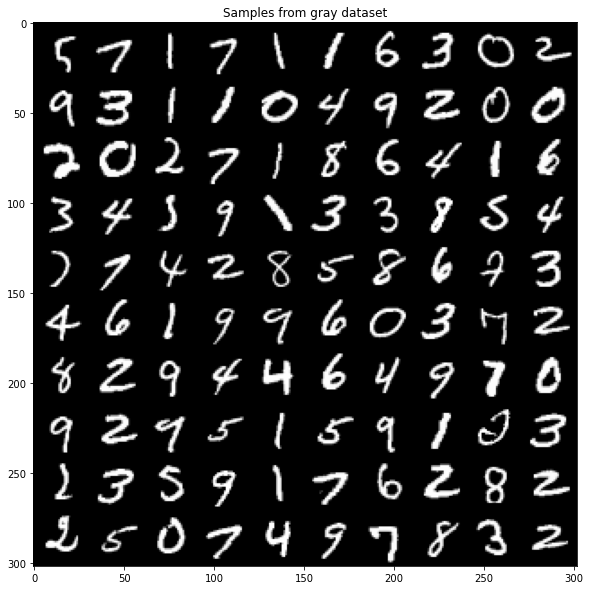

In [50]:
def make_image_grid(images, nrow=8):
    images = images.float()  # from {0,1,2,3} ints to [0,1] floats
    grid = torchvision.utils.make_grid(images, nrow)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    return grid

plt.figure(figsize=(10,10))
plt.title('Samples from gray dataset')
it = iter(train_dataset_gray)

imgs = []
labels = []
for i in range(100):
    element = next(it)
    imgs.append(element[0])
    labels.append(element[1])

labels = np.array(labels).reshape((10, 10))
    
plt.imshow(make_image_grid(torch.stack([next(it)[0] for _ in range(100)], dim=0), nrow=10))
del it

torch.Size([1, 28, 28])


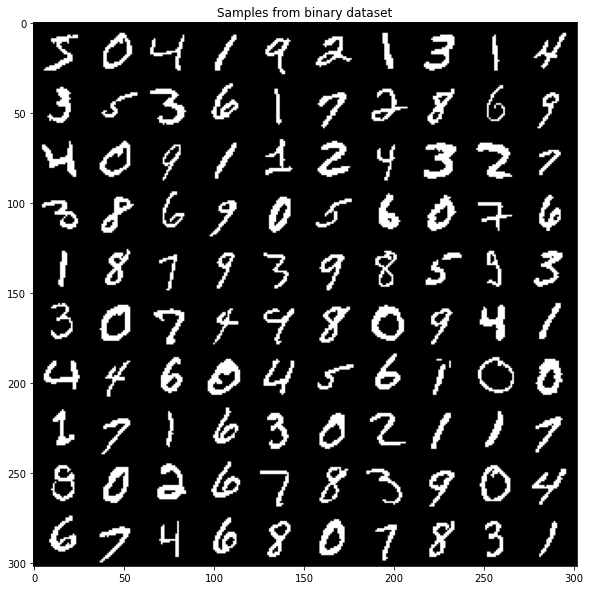

In [51]:
plt.figure(figsize=(10,10))
plt.title('Samples from binary dataset')
it = iter(train_dataset_binary)

imgs = []
labels = []
for i in range(100):
    element = next(it)
    imgs.append(element[0])
    labels.append(element[1])

labels = np.array(labels).reshape((10, 10))
    
plt.imshow(make_image_grid(torch.stack(imgs, dim=0), nrow=10))
print(imgs[0].size())
del it

In [52]:
class LabelToImageNet(nn.Module):
    
    def __init__(self, output_size=28*28):
        super().__init__()
        
        self.hidden_1 = nn.Linear(10, 20)
        self.hidden_2 = nn.Linear(20, 10)
        self.hidden_3 = nn.Linear(10, 10)
        self.hidden_4 = nn.Linear(10, 250)
        self.hidden_5 = nn.Linear(250, 500)
        self.hidden_6 = nn.Linear(500, 28*28)
        #self.hidden_3 = nn.Linear(500, 250)
        #self.hidden_4 = nn.Linear(250, 28*28)
        #self.hidden_5 = nn.Linear(*16, 28*28)        
    
    def forward(self, x):
        x = torch.Tensor([[int(i == z) for i in range(10)] for z in x]).to(device).float()
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.hidden_4(x)
        x = F.relu(x)
        x = self.hidden_5(x)
        x = F.relu(x)
        x = self.hidden_6(x)
        #x = F.relu(x)
        x = torch.sigmoid(x)
        return x

def get_sequential_model():
    return nn.Sequential(
        nn.Linear(1, 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 250),
        nn.ReLU(),
        nn.Linear(250, 500),
        nn.ReLU(),
        nn.Linear(500, 28*28),
        nn.Sigmoid()
    )


In [53]:
lr = 1e-3
reg = 1e-4
batch_size = 256
hidden_size = 64  # h variable in PixelCNN
num_residual_blocks = 12
num_feature_maps = 128  # size of the hidden output layer
batch_norm = True
num_input_channels = 1
num_output_classes = 2
flatten_img_size = 28 * 28


def sample_mnist_pixel_cnn(model, n_classes):
    outputs = []
    for i in range(n_classes):
        print()
        outputs.append(
            torch.reshape(
                model(torch.tensor([i]).to(device).float()),
                (1, 28, 28)
                )
            )
    return torch.stack(outputs, dim=0)


In [58]:
# alternatively model = torch.nn.Sequential( ?? )

optimizer = optim.Adam(model.parameters(), lr, weight_decay=reg)
cross_entropy = nn.CrossEntropyLoss()

def cross_entropy_processor(output):
    return torch.stack([torch.flatten(1-output), torch.flatten(output)], dim=1)

def flatten_processor(output):
    return torch.flatten(output)

def make_float_processor(imgs):
    return imgs.float()

def make_long_processor(imgs):
    return imgs.long()


def train(model, train_loder, val_loader, output_processor, imgs_processor, loss, save_img_path, n_epochs=100):
    writer = SummaryWriter()
    
    train_nll_history = []
    val_nll_history = []


    num_epochs = n_epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs} ', end='')
        
        model.train()
        for i, minibatch in enumerate(train_loader):
            optimizer.zero_grad()
            labels = torch.reshape(minibatch[1].to(device), (-1, 1)).float()
            imgs = torch.flatten(torch.reshape(minibatch[0].to(device), (-1, flatten_img_size)))

            output = model(labels)

            #print(torch.flatten(output))
            #print(imgs.float())
            nll = nn.MSELoss()(torch.flatten(output), imgs.float())

            #nll = loss(output_processor(output), imgs_processor(imgs))
            nll.backward()
            optimizer.step()
            
            train_nll_history.append(nll.item() / np.log(2.) / 2.)
            
            if i % 50 == 0:
                print('.', end='')
        
        train_loss = np.mean(train_nll_history) / np.log(2.) / 2.
        writer.add_scalar("Loss/train", train_loss, epoch)

        # compute nll on validation set
        val_nlls = []
        model.eval()
        with torch.no_grad():
            for val_minibatch in val_loader:
                val_labels = torch.reshape(minibatch[1].to(device), (-1, 1)).float()
                val_imgs = torch.flatten(torch.reshape(minibatch[0].to(device), (-1, flatten_img_size)))

                output = model(val_labels)
                
                val_nll = nn.MSELoss()(torch.flatten(output), val_imgs.float())

                #val_nll = loss(output_processor(output), imgs_processor(val_imgs))
                val_nlls.append(val_nll.item())
        val_loss = np.mean(val_nlls) / np.log(2.) / 2.

        writer.add_scalar("Loss/val", val_loss, epoch)
        val_nll_history.append(val_loss)
        print("loss: ", val_loss)
        
        samples = sample_mnist_pixel_cnn(model, 10).detach()
        #plt.figure(figsize=(6,3))
        img = make_image_grid(samples, nrow=5)
        plt.imsave(os.path.join(save_img_path, 'epoch_' + str(epoch) + '.jpg'), img)
        #plt.imshow(img)
        #plt.show()
    
    writer.flush()

    return val_nll_history, train_nll_history

### nn.Module with Binary images and Cross entropy loss

In [17]:
model = LabelToImageNet().to(device)

train(model, train_loader, val_loader, cross_entropy_processor, make_long_processor, cross_entropy, './data/nn_module_binary_crooss_entropy', n_epochs=100)


Epoch 1/100 .....loss:  0.3077309434481042










Epoch 2/100 .....loss:  0.30068027819983845










Epoch 3/100 .....loss:  0.30200331923509466










Epoch 4/100 .....loss:  0.3006742373092269










Epoch 5/100 .....loss:  0.3010292739941018










Epoch 6/100 .....loss:  0.3015482316430803










Epoch 7/100 .....loss:  0.300234133705669










Epoch 8/100 .....loss:  0.3012738548214601










Epoch 9/100 .....loss:  0.3013419814490331










Epoch 10/100 .....loss:  0.29985222473159673










Epoch 11/100 .....loss:  0.2959714792105402










Epoch 12/100 .....loss:  0.2970883130474119










Epoch 13/100 .....loss:  0.2995593812728401










Epoch 14/100 .....loss:  0.3007734927966061










Epoch 15/100 .....loss:  0.29910592751600895










Epoch 16/100 .....loss:  0.29899845985705104










Epoch 17/100 .....loss:  0.2986851504628417










Epoch 18/100 .....loss:  0.3000839068601403










Epoch 19/100 .....loss:  0.297983

([0.3077309434481042,
  0.30068027819983845,
  0.30200331923509466,
  0.3006742373092269,
  0.3010292739941018,
  0.3015482316430803,
  0.300234133705669,
  0.3012738548214601,
  0.3013419814490331,
  0.29985222473159673,
  0.2959714792105402,
  0.2970883130474119,
  0.2995593812728401,
  0.3007734927966061,
  0.29910592751600895,
  0.29899845985705104,
  0.2986851504628417,
  0.3000839068601403,
  0.29798331076250195,
  0.296235859540579,
  0.2988975490366573,
  0.2979157000828815,
  0.30191449019592403,
  0.2960345323499127,
  0.2988641844023899,
  0.29942654617287995,
  0.2945700355843219,
  0.29494373238681537,
  0.30068816790394676,
  0.3027048794636268,
  0.29758811612865055,
  0.2942630680503631,
  0.29815636830493264,
  0.29912938165002034,
  0.2984736547979432,
  0.2990418639785625,
  0.3018249947239813,
  0.29717785151501735,
  0.30018311935185676,
  0.29748957006970617,
  0.29802583347292777,
  0.29879891698638744,
  0.2991216854263942,
  0.296849042184399,
  0.2955117480869

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

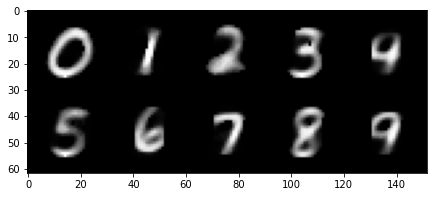

In [21]:
samples = sample_mnist_pixel_cnn(model, 10).detach()
plt.figure(figsize=(12, 3))
img = make_image_grid(samples, nrow=5)
plt.imshow(img)

### nn.Sequential with Binary images and Cross entropy loss

### nn.Sequential with Gray images and MSE loss

In [59]:
train_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))

model_seq = get_sequential_model().to(device)
train(model_seq, train_loader, val_loader, flatten_processor, make_float_processor, nn.MSELoss(), './data/sequential_gray_mse', n_epochs=50)

Epoch 1/50 .....loss:  0.16676933001828864










Epoch 2/50 .....loss:  0.16731478374441572










Epoch 3/50 .....loss:  0.1676097984841395










Epoch 4/50 ..

KeyboardInterrupt: 

In [39]:
# model_n_device = model_seq.to(device)
samples = samples = sample_mnist_pixel_cnn(model_n_device, 10).detach()
plt.figure(figsize=(12, 3))
img = make_image_grid(samples, nrow=5)
plt.imshow(img)

RuntimeError: mat1 dim 1 must match mat2 dim 0 mat1 dim1:1 mat2 dim0: 10

### nn.Sequential with Binary images and MSE loss

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))

model_seq = get_sequential_model()
train(model, train_loader, val_loader, mse_processor, make_float_processor, nn.MSELoss(), './data/sequential_binary_mse', n_epochs=100)

In [ ]:
samples = sample_mnist_pixel_cnn(model_seq, 10).detach()
plt.figure(figsize=(12, 3))
img = make_image_grid(samples, nrow=5)
plt.imshow(img)

Grayscaled images for the MSE loss give model less penalty in being incorrect on the border. Therefore model learns faster and get a local optimum faster. It will not be less accurate, because there is no exact and correct image corresponding to the given label, each prediction will be somewhat wrong, because for the same label we give different "correct" images for calculating loss. 

Grayscaled images for the crossentropy loss represent s

In [61]:
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))


model = LabelToImageNet().to(device)

train(model, train_loader, val_loader, cross_entropy_processor, make_long_processor, cross_entropy, './data/test', n_epochs=100)

Epoch 1/100 .....loss:  0.18046638304722012










Epoch 2/100 .....loss:  0.1805177628641654










Epoch 3/100 .....loss:  0.1804656306231226










Epoch 4/100 .....loss:  0.1805129688477726










Epoch 5/100 .

KeyboardInterrupt: 